In [ ]:
import sparql
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

In [1]:
# set up end point and prefix
endpoint = "http://virtuoso.nkn.uidaho.edu:8890/sparql/"

# attach SPARQL querry prefix. Note: the graph for our study should be updated
sparql_prefix = """ 
    prefix tssc: <http://deeptimekb.org/tssc#> 
    prefix tsnc: <http://deeptimekb.org/tsnc#> 
    prefix tswe: <http://deeptimekb.org/tswe#> 
    prefix tsbr: <http://deeptimekb.org/tsbr#>
    prefix tsba: <http://deeptimekb.org/tsba#> 
    prefix tsjp: <http://deeptimekb.org/tsjp#> 
    prefix tsau: <http://deeptimekb.org/tsau#>                   
    prefix tsnc: <http://deeptimekb.org/tsnc#> 
    prefix dc: <http://purl.org/dc/elements/1.1/> 
    prefix dcterms: <http://purl.org/dc/terms/> 
    prefix foaf: <http://xmlns.com/foaf/0.1/> 
    prefix geo: <http://www.opengis.net/ont/geosparql#> 
    prefix gts: <http://resource.geosciml.org/ontology/timescale/gts#> 
    prefix isc: <http://resource.geosciml.org/classifier/ics/ischart/> 
    prefix owl: <http://www.w3.org/2002/07/owl#> 
    prefix rank: <http://resource.geosciml.org/ontology/timescale/rank/> 
    prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
    prefix samfl: <http://def.seegrid.csiro.au/ontology/om/sam-lite#> 
    prefix sf: <http://www.opengis.net/ont/sf#> 
    prefix skos: <http://www.w3.org/2004/02/skos/core#> 
    prefix sosa: <http://www.w3.org/ns/sosa/> 
    prefix thors: <http://resource.geosciml.org/ontology/timescale/thors#> 
    prefix time: <http://www.w3.org/2006/time#> 
    prefix ts: <http://resource.geosciml.org/vocabulary/timescale/> 
    prefix vann: <http://purl.org/vocab/vann/> 
    prefix void: <http://rdfs.org/ns/void#> 
    prefix xkos: <http://rdf-vocabulary.ddialliance.org/xkos#> 
    prefix xsd: <http://www.w3.org/2001/XMLSchema#>
    
        """

In [2]:
sparql_prefix2 = sparql_prefix + """
                   SELECT DISTINCT ?schURI ?lbl
                   WHERE
                   {
                     GRAPH <http://deeptimekb.org/iscallnew> 
                     {
                        ?schURI a skos:ConceptScheme ;
                                rdfs:label ?lbl .
                        FILTER regex(?lbl, "International", "i")
                     }      
                   }
                   ORDER BY DESC (?schURI)
                   LIMIT 1
                  """

result = sparql.query(endpoint, sparql_prefix2)
latest = [sparql.unpack_row(row) for row in result][0][0]

In [3]:
sparql_prefix2 = sparql_prefix + f"""
   SELECT DISTINCT (str(?spLabel) AS ?label1) (str(?spCoordinates) AS ?coord1)
WHERE
{'{'}
            
GRAPH <http://deeptimekb.org/iscallnew>
{'{'}   
   ?bdry  a gts:GeochronologicBoundary ;
           dc:description
           [
             gts:stratotype ?baseSp ;
             skos:inScheme <{latest}>
           ] .
    
   ?baseSp samfl:shape ?spLocation ;  
           rdfs:label ?spLabel ;
           gts:ratifiedGSSP ?tf . 
    FILTER(regex(str(?tf), "true", "i"))

   ?spLocation geo:asWKT ?spCoordinates .
{'}'}

{'}'}
                  """
result = sparql.query(endpoint, sparql_prefix2)
rows = [
    tuple(map(float, sparql.unpack_row(row)[1].replace("POINT", '').replace("(", '').replace(")", '').split()))
    for row in result]

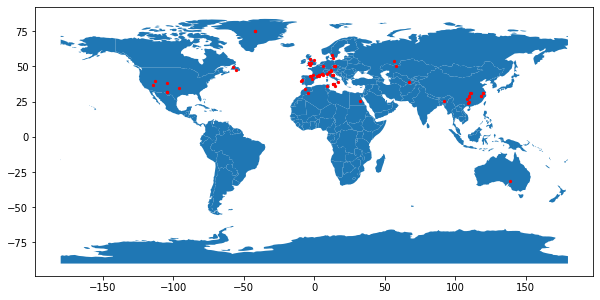

In [4]:
d = {'Longitude': [], 'Latitude': []}
for row in rows:
    d['Longitude'].append(row[0])
    d['Latitude'].append(row[1])

df = pd.DataFrame(data=d)
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

# this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=5)
plt.show()